## Metric: &thinsp; ROME - Radar Organization MEtric

ROME - organisation metric calculated from contiguous convective regions <br>
ROME_n - organisation metric calculated from the n (8) largest contiguous convective regions

In [13]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import seaborn as sns
import skimage.measure as skm

import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

import os
import sys
home = os.path.expanduser("~") + '/Documents'
sys.path.insert(0, '{}/code/phd/functions'.format(home))
from myFuncs import *

### one dataset

In [14]:
metric = 'rome'

rome_options= [
    'rome'
    # 'rome_n'
    ]

models_cmip5 = [
    # 'IPSL-CM5A-MR', # 1
    # 'GFDL-CM3',     # 2
    # 'GISS-E2-H',    # 3 
    # 'bcc-csm1-1',   # 4 
    # 'CNRM-CM5',     # 5
    # 'CCSM4',        # 6 
    # 'HadGEM2-AO',   # 7 
    # 'BNU-ESM',      # 8
    # 'EC-EARTH',     # 9 
    # 'FGOALS-g2',    # 10
    # 'MPI-ESM-MR',   # 11
    # 'CMCC-CM',      # 12
    # 'inmcm4',       # 13 
    # 'NorESM1-M',    # 14
    # 'CanESM2',      # 15
    # 'MIROC5',       # 16
    # 'HadGEM2-CC',   # 17 
    # 'MRI-CGCM3',    # 18
    # 'CESM1-BGC'     # 19 
    ]

models_cmip6 = [     
    'TaiESM1',        # 1
    # 'BCC-CSM2-MR',    # 2
    # 'FGOALS-g3',      # 3
    # 'CNRM-CM6-1',     # 4
    # 'MIROC6',         # 5
    # 'MPI-ESM1-2-HR',  # 6
    # 'NorESM2-MM',     # 7
    # 'GFDL-CM4',       # 8
    # 'CanESM5',        # 9
    # 'CMCC-ESM2',      # 10
    # 'UKESM1-0-LL',    # 11
    # 'MRI-ESM2-0',     # 12
    # 'CESM2',          # 13
    # 'NESM3'           # 14
    ]

datasets = models_cmip5 + models_cmip6

observations = [
    # 'GPCP'
    ]

datasets = models_cmip5 + models_cmip6 + observations

resolutions = [
    # 'original',
    'regridded'
    ]

experiments = [
    'historical',
    # 'rcp85',
    # 'ssp585'
    ]

print('variable:{}, dataset:{}, experiment:{}, resolution:{}'.format(metric, datasets[0], experiments[0], resolutions[0]))
ds = get_metric(metric, datasets[0], experiments[0], resolution=resolutions[0])
ds

variable:rome, dataset:TaiESM1, experiment:historical, resolution:regridded


<xarray.Dataset>
Dimensions:  (time: 10950)
Coordinates:
  * time     (time) object 1970-01-01 12:00:00 ... 1999-12-31 12:00:00
Data variables:
    rome     (time) float64 ...
    rome_n   (time) float64 ...
Attributes:
    description:  ROME based on all and the 8 largest objects in the scene fo...

In [15]:
data = ds[rome_options[0]]
data

<xarray.DataArray 'rome' (time: 10950)>
array([652515.163261, 617894.559385, 836478.28675 , ..., 427517.71295 ,
       575986.256856, 529325.180912])
Coordinates:
  * time     (time) object 1970-01-01 12:00:00 ... 1999-12-31 12:00:00
Attributes:
    units:    km²

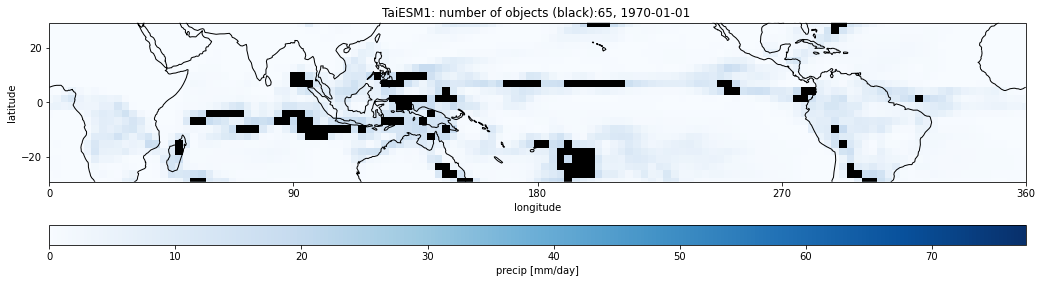

In [16]:
scene = get_dsvariable('precip', datasets[0],experiments[0],home, resolutions[0])['precip'].isel(time=0)
conv_threshold = get_metric('prPercentiles', datasets[0], experiments[0])['pr97'].mean(dim=('time'))

lat = scene.lat
lon = scene.lon
lonm,latm = np.meshgrid(lon,lat)

obj = skm.label(scene.where(scene>=conv_threshold,0)>0, background=np.nan,connectivity=2)
obj = (obj>0)*1
labelMatrix = xr.DataArray(
    data=obj,
    dims=['lat', 'lon'],
    coords={'lat': scene.lat.data, 'lon': scene.lon.data}
    )
obj = labelMatrix.where(labelMatrix>0)


fig= plt.figure(figsize=(17.5,8))
ax = fig.add_subplot(projection=cartopy.crs.PlateCarree(central_longitude=180))

ax.add_feature(cartopy.feature.COASTLINE)
ax.set_extent([lon[0], lon[-1], lat[0], lat[-1]], crs=cartopy.crs.PlateCarree())

pcm = ax.pcolormesh(lonm,latm, scene,transform=cartopy.crs.PlateCarree(),zorder=0, cmap='Blues') #, vmin=10, vmax=50)
ax.pcolormesh(lonm,latm, obj,transform=cartopy.crs.PlateCarree(), cmap='Greys_r')

ax.set_title(datasets[0] + ': number of objects (black):' + str(data.isel(time=0).values)[:2] + ', ' + str(scene.coords['time'].values)[:11] )
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')

ax.set_yticks([-20, 0, 20])
ax.set_xticks([-180, -90, 0, 90, 180])
ax.set_xticklabels([0, 90, 180, 270, 360])

plt.colorbar(pcm, ax=ax, orientation='horizontal',pad=0.10, aspect=50, fraction=0.055, label = 'precip' + ' [mm/day]')

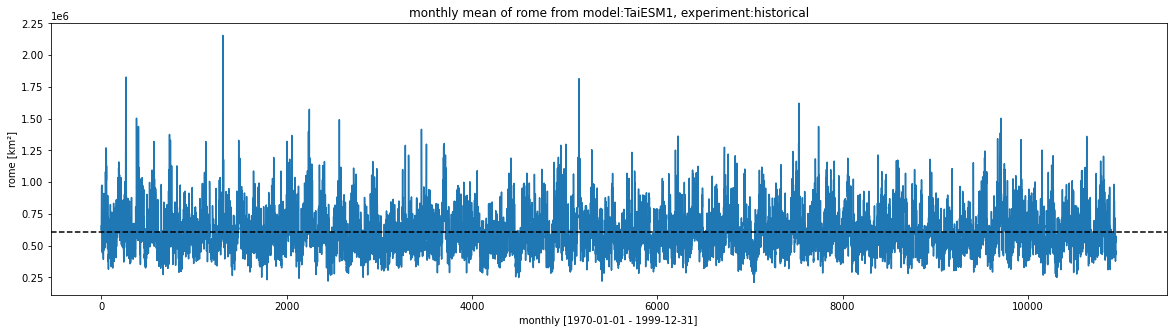

In [17]:
timeMean_options = [
    # 'annual',
    # 'seasonal',
    'monthly',
    # 'daily'
    ]

y= data
title = '{} mean of {} from model:{}, experiment:{}'.format(timeMean_options[0], rome_options[0], datasets[0], experiments[0])
xlabel = '{} [{} - {}]'.format(timeMean_options[0], str(data.isel(time=0).coords['time'].values)[:10], str(data.isel(time=-1).coords['time'].values)[:10])
ylabel = '{} [{}]'.format(rome_options[0], data.units)


plot_timeseries(y, title=title, timeMean_option=timeMean_options)
plt.xlabel(xlabel)
plt.ylabel(ylabel)

if timeMean_options[0]=='seasonal':
    plt.legend()

### comparing datasets

In [18]:
metric = 'rome'

models_cmip5 = [
    # 'IPSL-CM5A-MR', # 1
    # 'GFDL-CM3',     # 2
    # 'GISS-E2-H',    # 3 
    # 'bcc-csm1-1',   # 4 
    # 'CNRM-CM5',     # 5
    # 'CCSM4',        # 6
    # 'HadGEM2-AO',   # 7
    # 'BNU-ESM',      # 8
    # 'EC-EARTH',     # 9 
    # 'FGOALS-g2',    # 10
    # 'MPI-ESM-MR',   # 11
    # 'CMCC-CM',      # 12
    # 'inmcm4',       # 13
    # 'NorESM1-M',    # 14
    # 'CanESM2',      # 15
    # 'MIROC5',       # 16
    # 'HadGEM2-CC',   # 17
    # 'MRI-CGCM3',    # 18
    # 'CESM1-BGC'     # 19
    ]

models_cmip6 = [     
    'TaiESM1',        # 1
    'BCC-CSM2-MR',    # 2
    'FGOALS-g3',      # 3
    'CNRM-CM6-1',     # 4
    'MIROC6',         # 5
    'MPI-ESM1-2-HR',  # 6
    'NorESM2-MM',     # 7
    'GFDL-CM4',       # 8
    'CanESM5',        # 9
    'CMCC-ESM2',      # 10
    'UKESM1-0-LL',    # 11
    'MRI-ESM2-0',     # 12
    'CESM2',          # 13
    'NESM3'           # 14
    ]

datasets = models_cmip5 + models_cmip6

observations = [
    # 'GPCP'
    ]

datasets = models_cmip5 + models_cmip6 + observations

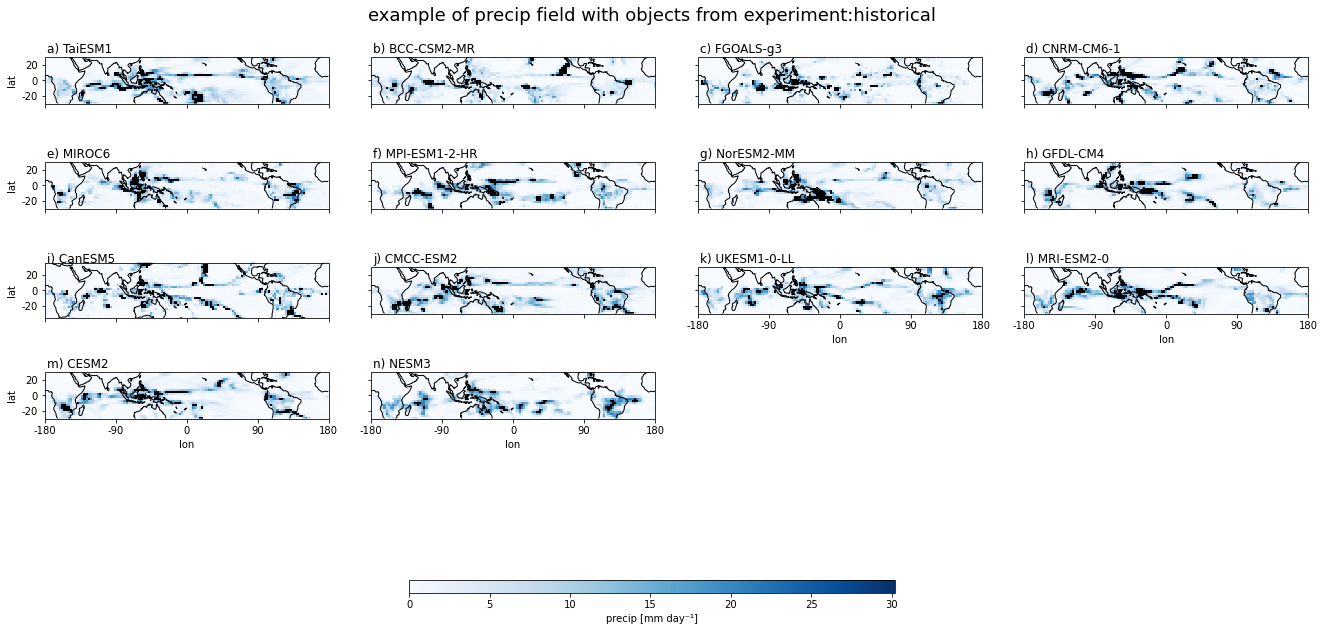

In [19]:
absolute_limits = True
quantile_low = 0
quantile_high = 0.975
if absolute_limits:
    vmin, vmax = [], []
    for dataset in datasets:

        data = get_dsvariable('precip', dataset,experiments[0],home, resolutions[0])['precip'].isel(time=0)
        y= data

        vmin = np.append(vmin, np.quantile(y, quantile_low))
        vmax = np.append(vmax, np.quantile(y, quantile_high))
    vmin = np.min(vmin)
    vmax = np.max(vmax)
else:
    vmin, vmax = None, None 

fig= plt.figure(figsize=(22.5,17.5))
title = 'example of {} field with objects from experiment:{}'.format('precip', experiments[0])

fig.suptitle(title, fontsize=18, x= 0.575, y=0.80)

for i, dataset in enumerate(datasets):
    ax= fig.add_subplot(5,4,i+1,projection=cartopy.crs.PlateCarree(central_longitude=180))

    scene = get_dsvariable('precip', dataset, experiments[0],home, resolutions[0])['precip'].isel(time=0)
    conv_threshold = get_metric('prPercentiles', dataset, experiments[0])['pr97'].mean(dim=('time'))

    lat = scene.lat
    lon = scene.lon
    lonm,latm = np.meshgrid(lon,lat)

    obj = skm.label(scene.where(scene>=conv_threshold,0)>0, background=np.nan,connectivity=2)
    obj = (obj>0)*1
    labelMatrix = xr.DataArray(
        data=obj,
        dims=['lat', 'lon'],
        coords={'lat': scene.lat.data, 'lon': scene.lon.data}
        )
    obj = labelMatrix.where(labelMatrix>0)

    ax.add_feature(cartopy.feature.COASTLINE)
    ax.set_extent([lon[0], lon[-1], lat[0], lat[-1]], crs=cartopy.crs.PlateCarree())

    pcm = ax.pcolormesh(lonm,latm, scene,transform=cartopy.crs.PlateCarree(),zorder=0, cmap='Blues', vmin=vmin, vmax=vmax)
    ax.pcolormesh(lonm,latm, obj,transform=cartopy.crs.PlateCarree(), cmap='Greys_r')

    letters='abcdefghijklmnopqrst'
    plt.text(-177.5, 35, letters[i] + ') ' + dataset, fontsize=12)
    ax.set_xticks([-180, -90, 0, 90, 180])
    ax.set_yticks([-20, 0, 20])
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    if (len(datasets)-i)<=4:
        xlabel = 'lon'
        plt.xlabel(xlabel)
        ax.set_xticklabels([-180, -90, 0, 90, 180])

    if i== 0 or i==4 or i==8 or i==12 or i==16:
        ylabel = 'lat'
        plt.ylabel(ylabel)
        ax.set_yticklabels([-20, 0, 20])

plt.subplots_adjust(left=0.2, bottom=0.2, right=0.98, top=0.95, wspace=0.15, hspace=-0.8)
cbar_ax = fig.add_axes([0.425, 0.335, 0.3, 0.01])
cbar = fig.colorbar(pcm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('{} [{}]'.format('precip', y.units))

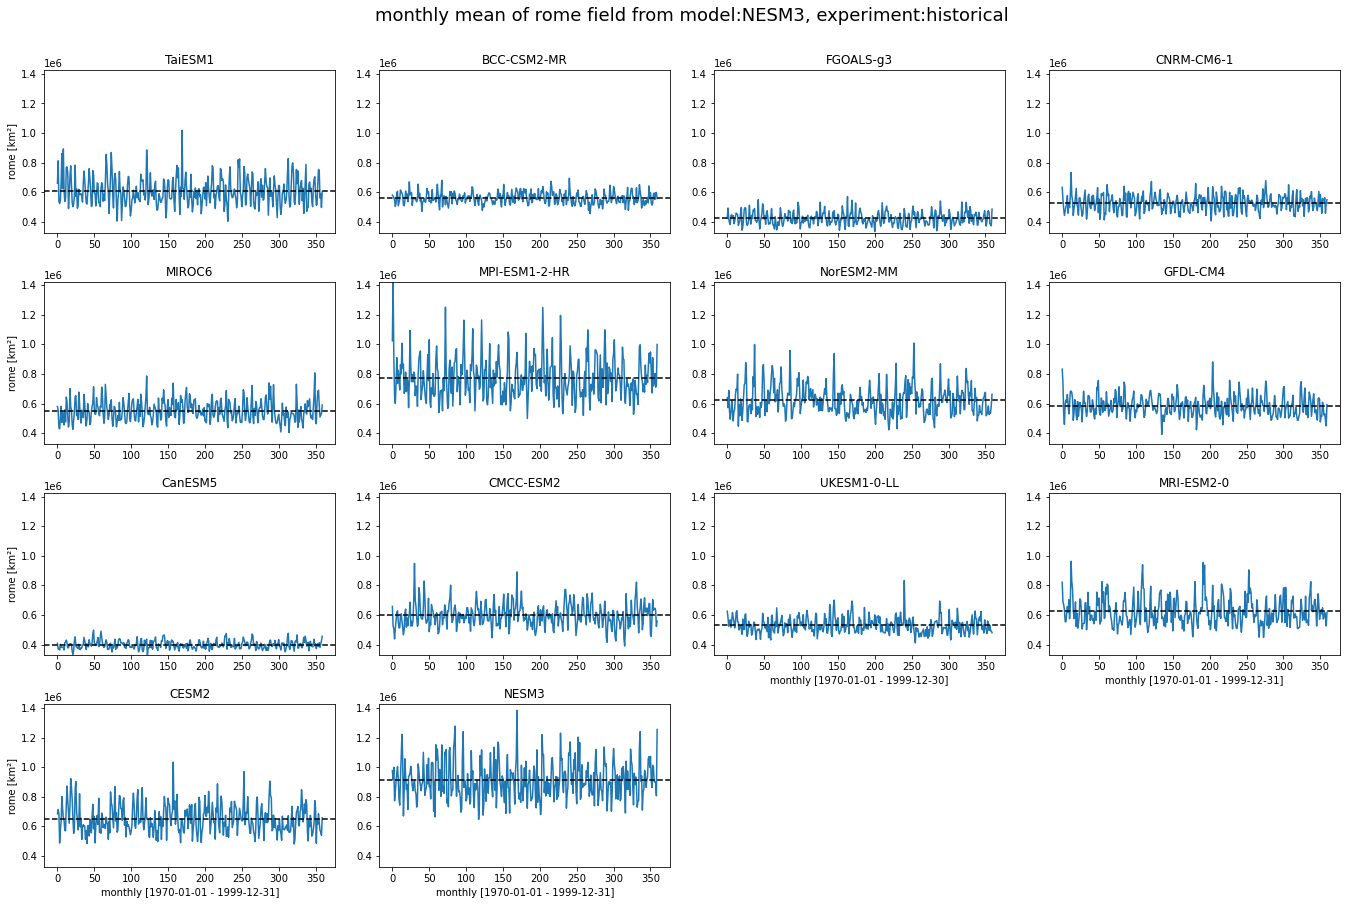

In [20]:
timeMean_options = [
    # 'annual',
    # 'seasonal',
    'monthly',
    # 'daily'
    ]

absolute_limits = True
quantile_low = 0
quantile_high = 1
if absolute_limits:
    vmin, vmax = [], []
    for dataset in datasets:

        data = get_metric(metric, dataset, experiments[0])[rome_options[0]]
        y = resample_timeMean(data, timeMean_options[0])

        vmin = np.append(vmin, np.quantile(y, quantile_low))
        vmax = np.append(vmax, np.quantile(y, quantile_high))
    vmin = np.min(vmin)
    vmax = np.max(vmax)
else:
    vmin, vmax = None, None 


fig= plt.figure(figsize=(22.5,17.5))
title = '{} mean of {} field from model:{}, experiment:{}'.format(timeMean_options[0], rome_options[0], dataset, experiments[0])

fig.suptitle(title, fontsize=18, y=0.95)
for i, dataset in enumerate(datasets):
    ax= fig.add_subplot(5,4,i+1)

    data = get_metric(metric, dataset, experiments[0])[rome_options[0]]
    y = resample_timeMean(data, timeMean_options[0])

    title = dataset
    plot_timeseries(y, title=title, timeMean_option=timeMean_options, ax=ax, ymin=vmin, ymax=vmax)

    if (len(datasets)-i)<=4:
        xlabel = '{} [{} - {}]'.format(timeMean_options[0], str(data.isel(time=0).coords['time'].values)[:10], str(data.isel(time=-1).coords['time'].values)[:10])
        plt.xlabel(xlabel)

        if timeMean_options[0]=='seasonal':
            plt.legend()

    if i== 0 or i==4 or i==8 or i==12 or i==16:
        ylabel = '{} [{}]'.format(rome_options[0], data.units)
        plt.ylabel(ylabel)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.15, hspace=0.3)

Text(0, 0.5, 'rome [km²]')

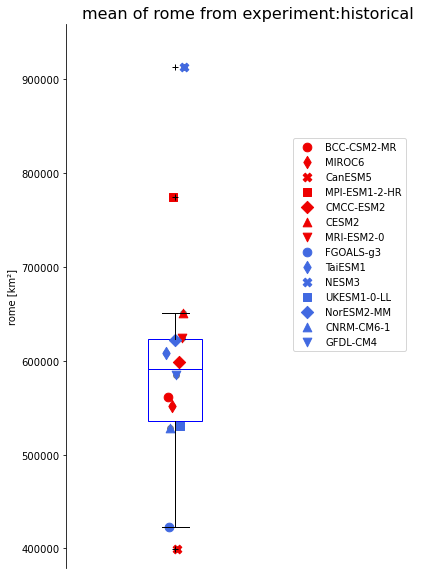

In [21]:
order, colors = orderByTas(True, datasets, experiments[0], resolutions[0])

absolute_limits = True
quantile_low = 0
quantile_high = 1
if absolute_limits:
    vmin, vmax = [], []
    for dataset in datasets:

        data = get_metric(metric, dataset, experiments[0])[rome_options[0]]
        y = data.mean(dim='time')

        vmin = np.append(vmin, np.quantile(y, quantile_low))
        vmax = np.append(vmax, np.quantile(y, quantile_high))
    vmin = np.min(vmin)
    vmax = np.max(vmax)

else:
    vmin, vmax = None, None 


plt.figure(figsize=(6.5,10))
title = 'mean of {} from experiment:{}'.format(rome_options[0], experiments[0])
plt.xlim(0,1)
plt.ylim(vmin*0.95, vmax*1.05)

y= []
for dataset in datasets:
        
    data = get_metric(metric, dataset, experiments[0])[rome_options[0]]
    y_data = data.mean(dim='time')

    y = np.append(y, y_data)

plt.boxplot(y,vert=True, positions= [0.3], patch_artist=True, medianprops = dict(color="b",linewidth=1),boxprops = dict(color="b",facecolor='w',zorder=0)
            ,sym='+',flierprops = dict(color="r"))

x = np.linspace(0.3-0.025, 0.3+0.025, len(y))
plt.scatter(x, y, c='k', alpha=0.4)

labels = datasets
if labels:
    datasets_order = np.array(datasets)[order]
    labels_order = datasets_order[np.isin(datasets_order, np.array(labels))].tolist()

    for i, label in enumerate(labels_order):
        dataset_idx= datasets.index(label)
        plt.scatter(x[dataset_idx],y[dataset_idx],c=colors[i], marker = markers[i%7], s=75,  label=label)
        
    plt.legend(bbox_to_anchor=(0.95,0.8))

plt.xticks([])
sns.despine(top=True, right=True, left=False, bottom=True)
plt.title(title, fontsize = 16)
plt.ylabel('{} [{}]'.format(rome_options[0], data.units))

Text(0, 0.5, 'rome [%K⁻¹]')

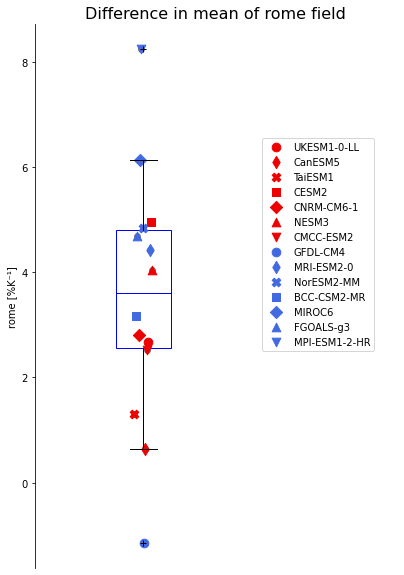

In [22]:
order, colors = orderByTasdiff(True, datasets, models_cmip5, resolutions[0])

absolute_limits = False
quantile_low = 0
quantile_high = 1
if absolute_limits:
    vmin, vmax = [], []
    for dataset in datasets:

        if dataset == 'GPCP':
            continue
        
        data_historical = get_metric(metric, dataset, experiment='historical')[rome_options[0]].mean(dim='time')
        if np.isin(models_cmip5, dataset).any():
            data_rcp = get_metric(metric, dataset, experiment='rcp85')[rome_options[0]].mean(dim='time')
        elif np.isin(models_cmip6, dataset).any():
            data_rcp = get_metric(metric, dataset, experiment='ssp585')[rome_options[0]].mean(dim='time')
        datadiff = data_rcp - data_historical

        fractional_change = True
        if fractional_change:
            datadiff = (datadiff/data_historical)*100

        divide_by_tasdiff = True
        if divide_by_tasdiff:
            tas_historical = get_metric('tas_sMean', dataset, experiment='historical', resolution=resolutions[0])['tas_sMean'].mean(dim='time')
            tas_rcp = get_metric('tas_sMean', dataset, experiment='rcp85', resolution=resolutions[0])['tas_sMean'].mean(dim='time')
            tasdiff = tas_rcp - tas_historical
            datadiff = datadiff/tasdiff

        y= datadiff

        vmin = np.append(vmin, np.quantile(y, quantile_low))
        vmax = np.append(vmax, np.quantile(y, quantile_high))
    vmin = np.min(vmin)
    vmax = np.max(vmax)
else:
    vmin, vmax = None, None 



plt.figure(figsize=(6.5,10))
title = 'Difference in mean of {} field'.format(rome_options[0])
plt.xlim(0,1)
# plt.ylim(vmin*0.95, vmax*1.05)

y= []
for dataset in datasets:

    if dataset == 'GPCP':
        continue

    data_historical = get_metric(metric, dataset, experiment='historical')[rome_options[0]].mean(dim='time')
    if np.isin(models_cmip5, dataset).any():
        data_rcp = get_metric(metric, dataset, experiment='rcp85')[rome_options[0]].mean(dim='time')
    elif np.isin(models_cmip6, dataset).any():
        data_rcp = get_metric(metric, dataset, experiment='ssp585')[rome_options[0]].mean(dim='time')
    datadiff = data_rcp - data_historical

    fractional_change = True
    if fractional_change:
        datadiff = (datadiff/data_historical)*100

    divide_by_tasdiff = True
    if divide_by_tasdiff:
        tas_historical = get_metric('tas_sMean', dataset, experiment='historical', resolution=resolutions[0])['tas_sMean'].mean(dim='time')
        if np.isin(models_cmip5, dataset).any():
            tas_rcp = get_metric('tas_sMean', dataset, experiment='rcp85', resolution=resolutions[0])['tas_sMean'].mean(dim='time')
        elif np.isin(models_cmip6, dataset).any():
            tas_rcp = get_metric('tas_sMean', dataset, experiment='ssp585', resolution=resolutions[0])['tas_sMean'].mean(dim='time')
        tasdiff = tas_rcp - tas_historical
        datadiff = datadiff/tasdiff


    y = np.append(y, datadiff)

# data.attrs['units'] = 'km\u00b2 K'+ chr(0x207B) + chr(0x00B9) 
    
plt.boxplot(y,vert=True, positions= [0.3], patch_artist=True, medianprops = dict(color="b",linewidth=1),boxprops = dict(color="b",facecolor='w',zorder=0)
            ,sym='+',flierprops = dict(color="r"))

x = np.linspace(0.3-0.025, 0.3+0.025, len(y))
plt.scatter(x, y, c='k', alpha=0.4)

if labels:
    datasets_order = np.array(datasets)[order]
    labels_order = datasets_order[np.isin(datasets_order, np.array(labels))].tolist()

    for i, label in enumerate(labels_order):
        dataset_idx= datasets.index(label)
        plt.scatter(x[dataset_idx],y[dataset_idx],c=colors[i], marker = markers[i%7], s=75,  label=label)
    
    plt.legend(bbox_to_anchor=(0.95,0.8))

# plt.ylim([3*vmin,1.1*vmax])
plt.xticks([])
sns.despine(top=True, right=True, left=False, bottom=True)
plt.title(title, fontsize = 16)
plt.ylabel('{} [{}]'.format(rome_options[0], '%' + 'K'+ chr(0x207B) + chr(0x00B9) ))

### other representations

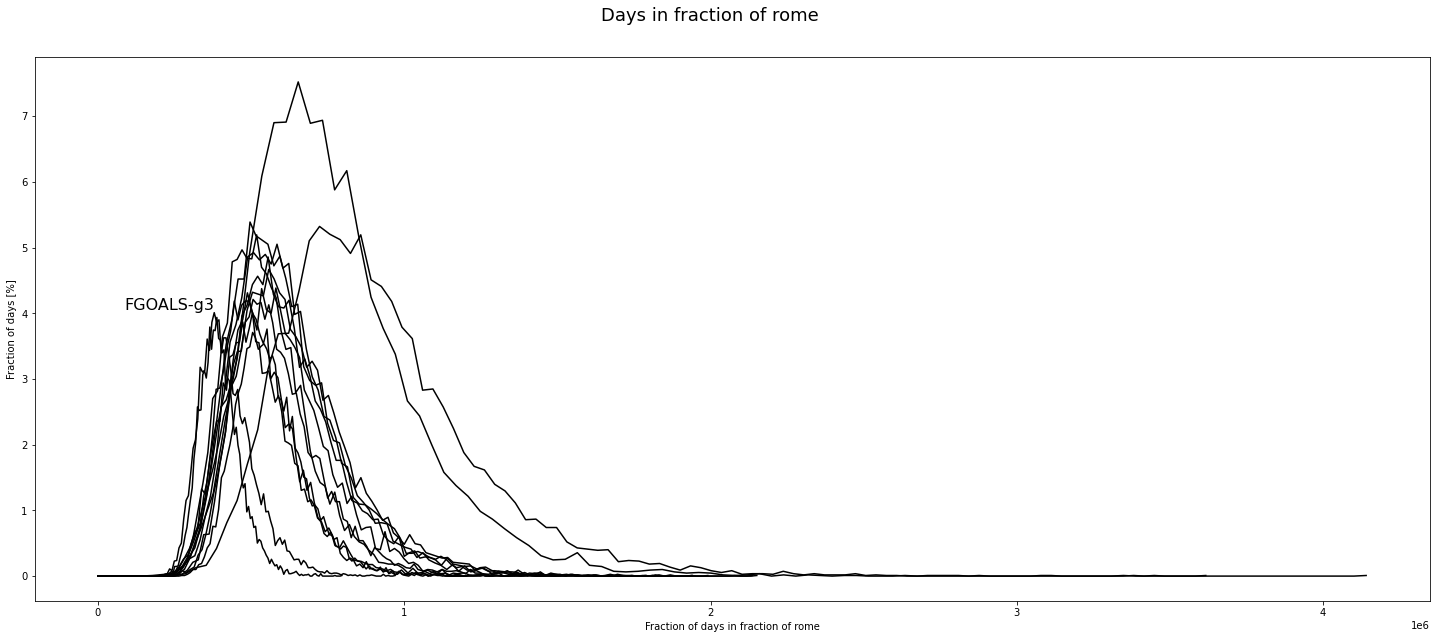

In [27]:
absolute_limits = True
quantile_low = 0
quantile_high = 1
if absolute_limits:
    vmin, vmax = [], []
    for dataset in datasets:

        data = get_metric(metric, dataset, experiments[0])[rome_options[0]]
        x= data

        vmin = np.append(vmin, np.quantile(x, quantile_low))
        vmax = np.append(vmax, np.quantile(x, quantile_high))
    vmin = np.min(vmin)
    vmax = np.max(vmax)
else:
    vmin, vmax = None, None 


fig= plt.figure(figsize=(25,10))
title = 'Days in fraction of rome'

fig.suptitle(title, fontsize=18, y=0.95)
for i, dataset in enumerate(datasets):

    data = get_metric(metric, dataset, experiments[0])[rome_options[0]]
    x= data
    
    bin_width = (x.max() - x.min())/100
    bin_end = x.max()
    bins = np.arange(0, bin_end+bin_width, bin_width)

    y_bins = []
    for i in np.arange(0,len(bins)-1):
        y_bins = np.append(y_bins, ((x>=bins[i]) & (x<bins[i+1])).sum())

    # place the distribution that falls between the edges of a bin in the middle of the bin, and describe that no objects have zero area
    y_bins_middle = np.append(0, y_bins)
    bins_middle = np.append(0,bins+0.5*bin_width.data) 
    
    ax = plt.gca()
    
    if dataset=='GPCP':
        ax.plot(bins_middle[:-1], y_bins_middle/len(x)*100, linewidth = 4, color = 'g')

    ax.plot(bins_middle[:-1], y_bins_middle/len(x)*100, 'k', zorder=0)

    max_index = np.argmax(y_bins_middle/len(x)*100)
    max_x = bins_middle[max_index]
    
    if dataset == 'bcc-csm1-1' or dataset == 'FGOALS-g3' or dataset == 'canESM2' or dataset == 'FGOALS-g2':
        ax.text(max_x, y_bins_middle[max_index]/len(x)*100, dataset, ha='right', va='bottom', fontsize=16, color='k')

    if dataset == 'GPCP':
        ax.text(max_x-20, (y_bins_middle[max_index]-2.5)/len(x)*100, dataset, fontsize=16, color='g', weight='bold') 


    ax.set_xlabel('Fraction of days in fraction of rome')
    ax.set_ylabel('Fraction of days [{}]'.format('%'))

Text(0.5, 1.0, 'fraction of days belonging to fraction of rome')

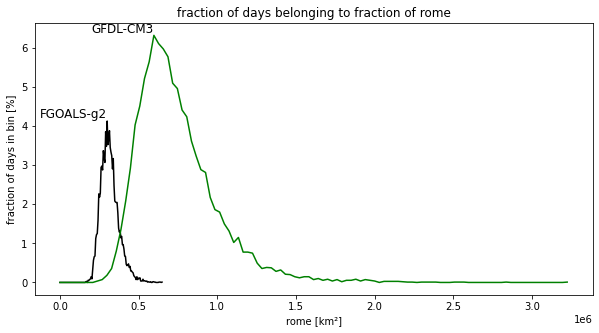

In [30]:
models = [
    # 'IPSL-CM5A-MR', # 1
    # 'GFDL-CM3',     # 2
    # 'GISS-E2-H',    # 3
    # 'bcc-csm1-1',   # 4
    # 'CNRM-CM5',     # 5
    # 'CCSM4',        # 6
    # 'HadGEM2-AO',   # 7
    # 'BNU-ESM',      # 8
    # 'EC-EARTH',     # 9
    # 'FGOALS-g2',    # 10
    # 'MPI-ESM-MR',   # 11
    # 'CMCC-CM',      # 12
    # 'inmcm4',       # 13
    # 'NorESM1-M',    # 14
    # 'CanESM2',      # 15
    # 'MIROC5',       # 16
    # 'HadGEM2-CC',   # 17
    # 'MRI-CGCM3',    # 18
    # 'CESM1-BGC'     # 19
    ]

observations = [
    # 'GPCP'
    ]

# dataset1 = 'FGOALS-g3'
# dataset2 = 'GFDL-CM4'

dataset1 = 'FGOALS-g2'
dataset2 = 'GFDL-CM3'

x = get_metric(metric=metric, dataset=dataset1, experiment = experiments[0], resolution=resolutions[0])[rome_options[0]]
bin_width = (x.max() - x.min())/100
bin_end = x.max()
bins = np.arange(0, bin_end+bin_width, bin_width)
y_bins = []
for i in np.arange(0,len(bins)-1):
    y_bins = np.append(y_bins, ((x>=bins[i]) & (x<bins[i+1])).sum())


x2 = get_metric(metric=metric, dataset=dataset2, experiment = experiments[0], resolution=resolutions[0])[rome_options[0]]
bin_width = (x2.max() - x2.min())/100
bin_end = x2.max()
bins2 = np.arange(0, bin_end+bin_width, bin_width)
y_bins2 = []
for i in np.arange(0,len(bins2)-1):
    y_bins2 = np.append(y_bins2, ((x2>=bins2[i]) & (x2<bins2[i+1])).sum())


plt.figure(figsize = (10,5))
ax = plt.gca()

ax.plot(bins[:-1], y_bins/len(x)*100, 'k')
max_index = np.argmax(y_bins)
max_x = bins[max_index]
ax.text(max_x, y_bins[max_index]/len(x)*100, dataset1, ha='right', va='bottom', fontsize=12, color='k')


ax.plot(bins2[:-1], y_bins2/len(x)*100, 'g')
max_index = np.argmax(y_bins2)
max_x = bins2[max_index]
ax.text(max_x, y_bins2[max_index]/len(x)*100, dataset2, ha='right', va='bottom', fontsize=12, color='k')


ax.set_xlabel('rome [{}]'.format('km\u00b2'))
ax.set_ylabel('fraction of days in bin [{}]'.format('%'))
ax.set_title('fraction of days belonging to fraction of rome')